# Example Integer Programming Solver with OR Tools

A hello world intro to mixed integer programming with or-tools.

Recall our workflow:

1. Import linear solver wrapper
2. Declare the LP solver (i.e. `MPsolver`, `GLOP`)
3. Create Variables (i.e. `solver.NumVar(lb, ub, name)`)
4. Add Constraints `solver.Add`
5. Define Objective `solver.Maximize()`
6. Invoke the solver `solver.Solve()`
7. Display the solution

First, the preamble:

In [2]:
# 1. Import solver wrapper
from ortools.linear_solver import pywraplp

## Scenario

Let's imagine that we are a party of 4 adventurers and want to equip ourselves with weapons that do the most damage if we only have 20 coins in our budget. We come to a shopkeeper that sells bows, axes, spears, and swords but only has a limited number of each weapon. Which weapons should we buy to maximize our damage output while staying under our 20 coin budget?

In [3]:
# Here's our imaginary dataset:
names = ['bow', 'axe', 'spear', 'sword']

data = {}
data['damage'] = [6., 12., 6., 10.]     # Damage for each item
data['cost'] = [5., 9., 4., 10.]        # Prices for each item
data['inventory'] = [2, 1, 3, 1]        # Shopkeeper inventory

# 2. Declare solver
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver("SCIP")

We essentially just have 4 decision variables that are the number of weapon that we want to buy.

In [4]:
# Array to hold our variables
weapons = [solver.IntVar(0.0, solver.infinity(), name) for name in names]

print("Number of Variables: ", solver.NumVariables())

Number of Variables:  4


In [5]:
#Constraints

cost_limit = 20
# 0 <= 5a + 12b + 6c + 4d <= cost_limit
constraint = solver.RowConstraint(0, cost_limit, "Cost Constraint")  # Sum of the coefficients must be less than or equal to the ub
for i in range(4):
    constraint.SetCoefficient(weapons[i], data['cost'][i])

# Can also state it as:
# constraint_expr = [data['weight'][i] * weapons[i] for i in range(4)]
# solver.Add(sum(constraint_expr) <= weight_limit)

# Inventory Level Constraint
for i in range(4):
    solver.Add(weapons[i] <= data['inventory'][i])

# Need at least 4 weapons
solver.Add(sum(weapons) >= 4)

print("Number of Constraints: ", solver.NumConstraints())

# Objective
objective = solver.Objective()
for j in range(4):
    objective.SetCoefficient(weapons[j], data['damage'][j])
objective.SetMaximization()


Number of Constraints:  6


In [6]:
# Invoke solver
print(f"Solving with {solver.SolverVersion()}")
status = solver.Solve()

print("Optimal Damage: ", solver.Objective().Value())
for j in range(len(data['damage'])):
    print(weapons[j], weapons[j].solution_value())

Solving with SCIP 8.0.4 [LP solver: Glop 9.8]
Optimal Damage:  24.000000000000004
bow 1.0
axe 0.0
spear 3.0
sword 0.0


# Promo Calendar Optimization

We have 12 months, which months should we promote and what price should we sell at?

In [99]:
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

# Constants
PRICE_ELASTICITY = -3
REGULAR_RETAIL_PRICE = 6.99
PRODUCT_MANUFACTURING_COST = 2
REGULAR_RETAIL_COST = 4.667
BASELINE_SALES = 500
RETAILER_MARGIN = 0.332

np.random.seed(99)
# Seasonality factors
seasonality = [np.random.uniform(0.5, 1) if w <= 3 or w >= 11 else
               np.random.uniform(0.8, 1.5) if w <= 9 else
               np.random.uniform(1.5, 2.5) for w in range(52)]

px.line(seasonality, title='Seasonality', template='simple_white')

First we need to find the optimal promo price.

In [100]:
# Consider discounts between 15-50% off.
discount = np.linspace(-0.15, -0.5, 50)
prices = (1 + discount) * REGULAR_RETAIL_PRICE
unit_sales = BASELINE_SALES * (1 + PRICE_ELASTICITY * discount)
promo_revenue = unit_sales * prices
px.line(x=prices, y=promo_revenue)

In [101]:
discount[np.argmax(promo_revenue)]

-0.33571428571428574

In [103]:
from scipy.optimize import minimize_scalar

def revenue_fn(discount, base_price, elasticity, base_sales=500):
    demand = base_sales * (1 + elasticity * discount)
    return -demand * ((1 + discount) * base_price)

res = minimize_scalar(revenue_fn, args=(6.99, -3), bounds=[-0.5, -0.15], method='bounded')
optimal_discount = res.x
print("Optimal Discount: ", optimal_discount)

Optimal Discount:  -0.33333333333333337


So the ideal discount is about 1/3

In [106]:
# 2. Declare solver
# Create the mip solver with the SCIP backend.
promo_solver = pywraplp.Solver.CreateSolver("SCIP")

# Decision Variables
month_nums = range(52)

# Which months to promote?
promo_months = [promo_solver.BoolVar(f"promo_month_{i}") for i in month_nums]
reg_months = [promo_solver.BoolVar(f"reg_month_{i}") for i in month_nums]

print("Number of variables: ", promo_solver.NumVariables())

# What price should we promote at?
promo_price = REGULAR_RETAIL_PRICE * (1 + optimal_discount)

# Demand
discount_pct = (promo_price/REGULAR_RETAIL_PRICE) - 1

# Constraints
# No more than 4 months of promotions
promo_solver.Add(sum(promo_months) <= 4)
promo_solver.Add(sum(promo_months) >= 1)

# Constraint that either we have a regular month or a promo month
for i in month_nums:
    promo_solver.Add(promo_months[i] + reg_months[i] == 1)

unit_sales = []
for i in month_nums:
    _promo_sales = BASELINE_SALES * seasonality[i] * (1+PRICE_ELASTICITY * discount_pct) * promo_price * promo_months[i]
    _reg_sales = BASELINE_SALES * seasonality[i] * REGULAR_RETAIL_PRICE * reg_months[i]
    unit_sales.append(_promo_sales)
    unit_sales.append(_reg_sales)

total_revenue = sum(unit_sales)
promo_solver.Maximize(total_revenue)

status = promo_solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print("Solution: ")
    print("Objective value =", promo_solver.Objective().Value())
    for i in month_nums:
        if promo_months[i].solution_value() >0:
            print(f"promo_month_{i} =", promo_months[i].solution_value())

Number of variables:  104
Solution: 
Objective value = 154928.90475648665
promo_month_4 = 1.0
promo_month_5 = 1.0
promo_month_8 = 1.0
promo_month_10 = 1.0


## Scratch

In [107]:
# Price elasticity of demand stuff
ped = -1.5
discount = np.linspace(-0.5, 0, 50)
price = (1+discount) * 6.99
initial_sales = 500

demand = (1 + ped * discount) * initial_sales
demand2 = (1 + -1.75 * discount) * initial_sales

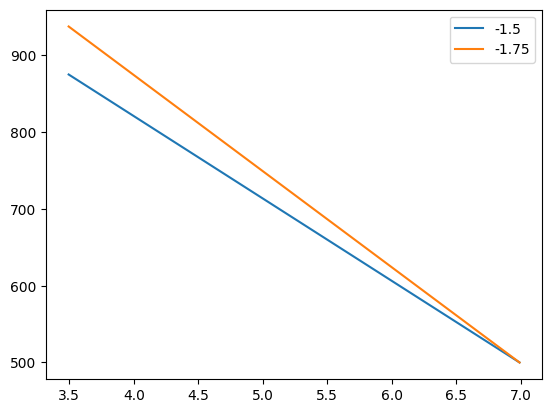

In [ ]:
plt.plot(price, demand, label='-1.5')
plt.plot(price, demand2, label='-1.75')
plt.legend()

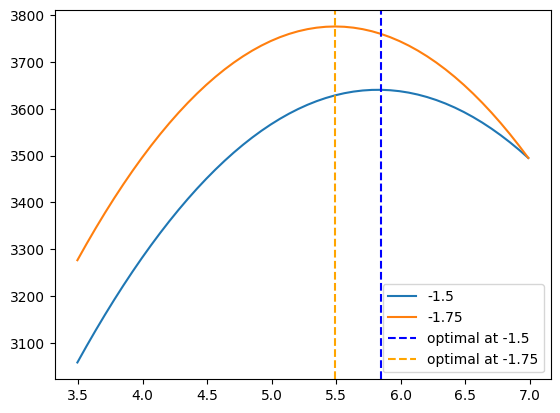

In [ ]:
revenue = price * demand
revenue2 = price * demand2

plt.plot(price, revenue, label='-1.5')
plt.plot(price, revenue2, label='-1.75')
plt.axvline(price[np.argmax(revenue)], linestyle='dashed', label='optimal at -1.5', color='blue')
plt.axvline(price[np.argmax(revenue2)], linestyle='dashed', label='optimal at -1.75', color='orange')
plt.legend()